**Goal**: 

Determine if Hassan transform renders some (CT) texture of firstorder features independent of GL discretization which leads to a reduction of the feature space dimensionality.

[Hassan supplementary matreial](https://static-content.springer.com/esm/art%3A10.1038%2Fs41598-018-28895-9/MediaObjects/41598_2018_28895_MOESM1_ESM.pdf)

**NOTE**
* Image voxels are 1 mm$^3$.

In [1]:
import os
import nrrd

from ioutil import sample_paths

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# Get number of GL

In [2]:
# NOTE: 
# * term `equispaced gray levels`.
# * the voxel intensities (gray levels) within the VOI are resampled to 2^N number of bins, where N 
#   ranges from 3 to 8.

# Bin widhts for Z-scored CT stacks.
width32 = 0.5403571428571429
width64 = 0.27017857142857143
width128 = 0.13508928571428572

# NOTE: Read from other image directory if not calc. bins for
# original images.
path_ct_stacks = sample_paths(
    './../../data_source/images/ct_nrrd/', 
    './../../data_source/images/masks_nrrd/', 
    target_format='nrrd'
)

gl_32bins = np.zeros(len(path_ct_stacks))
gl_64bins = np.zeros(len(path_ct_stacks))
gl_128bins = np.zeros(len(path_ct_stacks))

for num, ct_path in enumerate(path_ct_stacks):
    
    image, _ = nrrd.read(ct_path['Image'])
    mask, _ = nrrd.read(ct_path['Mask'])
    
    _cropped = image * mask
    cropped = _cropped[_cropped != 0]
        
    # NOTE: Z-scoring for CT texture features.
    cropped = (cropped - np.mean(cropped)) / (np.std(cropped) + + 1e-10)
    
    data = cropped.ravel()
    
    # Binning operation as conducted in PyRadiomics.
    minimum = min(data)
    maximum = max(data)

    low_32_bound = minimum - (minimum % width32)
    low_64_bound = minimum - (minimum % width64)
    low_128_bound = minimum - (minimum % width128)

    high_32_bound = maximum + 2 * width32
    high_64_bound = maximum + 2 * width64
    high_128_bound = maximum + 2 * width128

    bin_32_edges = np.arange(low_32_bound, high_32_bound, width32)
    bin_64_edges = np.arange(low_64_bound, high_64_bound, width64)
    bin_128_edges = np.arange(low_128_bound, high_128_bound, width128)
    
    gl_32bins[num] = np.size(bin_32_edges)
    gl_64bins[num] = np.size(bin_64_edges)
    gl_128bins[num] = np.size(bin_128_edges)

In [3]:
# The average number of bins per GL discretization for the CURRENT images.
np.mean(gl_32bins), np.mean(gl_64bins), np.mean(gl_128bins)

(35.76262626262626, 68.52525252525253, 134.16666666666666)

In [4]:
# https://github.com/cosanlab/nltools/blob/master/nltools/data/brain_data.py
# https://www.aliquote.org/cours/2012_biomed/biblio/Shrout1979.pdf
def icc(X):
    """Calculate intraclass correlation coefficient (ICC). 
    
    Reference: 
        Shrout, P. E., & Fleiss, J. L. (1979). Intraclass correlations: uses in
        assessing rater reliability. Psychological bulletin, 86(2), 420.
    
    Args:
        X (array-like): Data matrix with observations on rows
            and measurements on columns.

    Returns:
        (float): Intraclass correlation coefficient.
                
    """
    n, k = np.shape(X)

    # Degrees of Freedom.
    dfc = k - 1
    dfe = (n - 1) * (k - 1)
    dfr = n - 1

    # Sum Square Total.
    mean_X = np.mean(X)
    SST = ((X - mean_X) ** 2).sum()

    # Create the design matrix for the different levels:
    # * Sessions.
    d = np.kron(np.eye(k), np.ones((n, 1)))  
    # * Subjects.
    d0 = np.tile(np.eye(n), (k, 1))  
    D = np.hstack([d, d0])

    # Sum Square Error.
    predicted_X = np.dot(
        np.dot(
            np.dot(
                D, np.linalg.pinv(np.dot(D.T, D))), D.T
            ), 
            X.flatten('F')
        )
    residuals = X.flatten('F') - predicted_X
    SSE = np.sum(residuals ** 2)
    MSE = SSE / dfe

    # Sum square column effect (between colums).
    SSC = np.sum((np.mean(X, 0) - mean_X) ** 2) * n
    MSC = SSC / dfc / n

    # Sum Square subject effect (between rows/subjects).
    SSR = SST - SSC - SSE
    MSR = SSR / dfr

    ICC = (MSR - MSE) / (MSR + (k - 1) * MSE)
    
    return ICC

In [5]:
features = pd.read_csv(
    './../../data_source/to_analysis/original_images/texture_original_images.csv',
    index_col=0
)
features.head()

,CT_original_glcm_Autocorrelation_32bins,CT_original_glcm_Autocorrelation_64bins,CT_original_glcm_Autocorrelation_128bins,CT_original_glcm_ClusterProminence_32bins,CT_original_glcm_ClusterProminence_64bins,CT_original_glcm_ClusterProminence_128bins,CT_original_glcm_ClusterShade_32bins,CT_original_glcm_ClusterShade_64bins,CT_original_glcm_ClusterShade_128bins,CT_original_glcm_ClusterTendency_32bins,...,PET_original_ngtdm_Coarseness_128bins,PET_original_ngtdm_Complexity_32bins,PET_original_ngtdm_Complexity_64bins,PET_original_ngtdm_Complexity_128bins,PET_original_ngtdm_Contrast_32bins,PET_original_ngtdm_Contrast_64bins,PET_original_ngtdm_Contrast_128bins,PET_original_ngtdm_Strength_32bins,PET_original_ngtdm_Strength_64bins,PET_original_ngtdm_Strength_128bins
2,15.835837,48.879403,159.175192,0.568382,4.436457,74.353620,-0.189067,-0.656599,-6.203428,0.081488,...,0.004674,864.264931,6317.905928,47911.538007,0.094467,0.178522,0.358077,6.056883,25.569402,101.349195
4,11.917136,40.804717,150.846648,2.494158,27.367789,416.195648,-0.253104,-3.083318,-25.933402,0.998702,...,0.007393,393.032158,2598.387661,19583.699051,0.070371,0.125212,0.238323,6.020627,27.041854,112.930692
5,23.695404,63.013916,231.810872,2.666043,26.308717,394.079421,-0.782760,-1.967129,-9.841202,0.571788,...,0.005148,289.478395,1888.479958,14251.786302,0.054862,0.099397,0.191059,2.465424,10.712513,44.413354
8,34.895257,118.113705,450.544195,17.429172,204.478150,3246.675728,-2.859567,-16.925186,-133.055739,0.638704,...,0.001351,198.658313,1132.477809,7766.449173,0.024057,0.038664,0.070972,0.557137,2.722718,11.764508
10,15.917349,48.319152,163.419029,0.462631,12.194580,235.850203,-0.118145,-1.925310,-18.828114,0.079443,...,0.005647,53.319314,331.744933,2230.353249,0.029615,0.044522,0.082681,0.583155,3.012160,12.723851


In [6]:
CT_texture = features.filter(regex='CT')
CT_texture.head()

,CT_original_glcm_Autocorrelation_32bins,CT_original_glcm_Autocorrelation_64bins,CT_original_glcm_Autocorrelation_128bins,CT_original_glcm_ClusterProminence_32bins,CT_original_glcm_ClusterProminence_64bins,CT_original_glcm_ClusterProminence_128bins,CT_original_glcm_ClusterShade_32bins,CT_original_glcm_ClusterShade_64bins,CT_original_glcm_ClusterShade_128bins,CT_original_glcm_ClusterTendency_32bins,...,CT_original_ngtdm_Coarseness_128bins,CT_original_ngtdm_Complexity_32bins,CT_original_ngtdm_Complexity_64bins,CT_original_ngtdm_Complexity_128bins,CT_original_ngtdm_Contrast_32bins,CT_original_ngtdm_Contrast_64bins,CT_original_ngtdm_Contrast_128bins,CT_original_ngtdm_Strength_32bins,CT_original_ngtdm_Strength_64bins,CT_original_ngtdm_Strength_128bins
2,15.835837,48.879403,159.175192,0.568382,4.436457,74.353620,-0.189067,-0.656599,-6.203428,0.081488,...,0.000516,0.328398,2.760792,48.928540,0.000121,0.000147,0.001191,0.058311,0.212325,0.270003
4,11.917136,40.804717,150.846648,2.494158,27.367789,416.195648,-0.253104,-3.083318,-25.933402,0.998702,...,0.001344,2.355871,10.804097,57.563202,0.006694,0.005612,0.007541,0.012391,0.061311,0.314579
5,23.695404,63.013916,231.810872,2.666043,26.308717,394.079421,-0.782760,-1.967129,-9.841202,0.571788,...,0.000818,2.436225,13.081698,101.732037,0.000960,0.001089,0.002216,0.039651,0.147817,0.551486
8,34.895257,118.113705,450.544195,17.429172,204.478150,3246.675728,-2.859567,-16.925186,-133.055739,0.638704,...,0.000126,2.145538,11.537561,173.691774,0.000489,0.000429,0.001738,0.024412,0.134288,0.282525
10,15.917349,48.319152,163.419029,0.462631,12.194580,235.850203,-0.118145,-1.925310,-18.828114,0.079443,...,0.001255,0.555761,3.410261,35.432126,0.000110,0.000399,0.001649,0.098368,0.249049,0.554381


In [7]:
# Hassan found 17 features with trend varying according to GL discr. 

# Ng is the number of discrete gray levels in the image.

# Feature definitions implemented by Hassan et al. were compared to the feature definitions 
# implemented in the PyRadiomics Python package.

# GLCM features normalized by the number of gray levels:
# * Entropy (found! named joint entropy in pyrad)
# * Diff. entropy (found!)
# * Sum entropy (found!)
# * Contrast (found!)
# * Mean (NOT found!)
# * Sum Variance (NOT found! deprecated in pyrad)
# * Difference Variance (found! try out, but DIFFERENT seems to be formula in pyrad)
# * Sum Average (found!)
# * Difference Average (found! try out, but DIFFERENT seems to be formula in pyrad)
# * Dissimilarity (NOT found!)


# GLRLM features normalized by the number of gray levels.
# * GLNU (found!)
# * HGRE (found!) 
# * SRHGE (found!)

# NGTDM features normalized by the number of gray levels.
# * Contrast (found!)
# * Complexity (found!)
# * Texture strength (found! names strength only in pyrad)

# GLSZM features normalized by the number of gray levels.
# * HIE (NOT found!)

# Intercorrelation Coefficient of all features

In [8]:
col_regexes = np.unique([('_').join(col.split('_')[:-1]) for col in features.columns])

assert col_regexes.size * 3 == features.columns.size

all_feat_icc = np.zeros(col_regexes.size)
for num, label in enumerate(col_regexes):
    all_feat_icc[num] = icc(features.filter(regex=label).values)
    
sum(all_feat_icc >= 0.9)

15

In [9]:
list(col_regexes[all_feat_icc >= 0.9])

['CT_original_glcm_Correlation',
 'CT_original_glcm_MCC',
 'CT_original_gldm_GrayLevelNonUniformity',
 'PET_original_glcm_Correlation',
 'PET_original_glcm_DifferenceEntropy',
 'PET_original_glcm_Idmn',
 'PET_original_glcm_Idn',
 'PET_original_glcm_Imc1',
 'PET_original_glcm_JointEntropy',
 'PET_original_glcm_MCC',
 'PET_original_glcm_SumEntropy',
 'PET_original_gldm_DependenceEntropy',
 'PET_original_gldm_SmallDependenceLowGrayLevelEmphasis',
 'PET_original_glrlm_RunEntropy',
 'PET_original_ngtdm_Coarseness']

In [10]:
df_icc_all_feats = pd.DataFrame(
    all_feat_icc[all_feat_icc >= 0.9],
    index=col_regexes[all_feat_icc >= 0.9],
    columns=['Score']
)

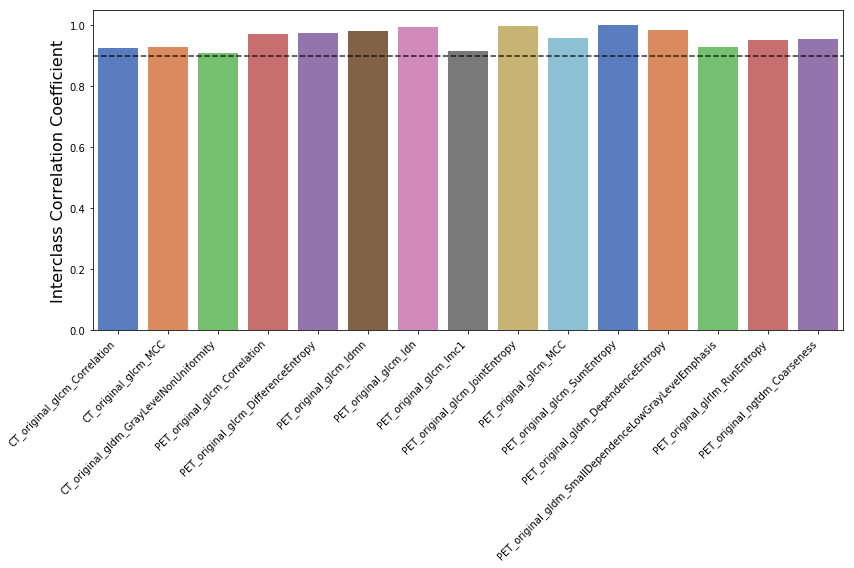

In [11]:
# Plotting features with ICC > 0.9.
plt.figure(figsize=(12, 8))
sns.barplot(
    x=df_icc_all_feats.index, 
    y='Score', 
    data=df_icc_all_feats, 
    #palette='PuBu',
    palette='muted',
)
plt.ylabel('Interclass Correlation Coefficient', fontsize='16')
plt.xticks(
    np.arange(df_icc_all_feats.index.size), df_icc_all_feats.index, rotation=45, ha='right'
)
plt.axhline(y=0.9, linestyle='--', alpha=0.8, color='k')#'darkblue')
plt.tight_layout()

# Hassan Transform of Selected Features

In [12]:
hassan_transforms = {
    'CT_original_glcm_DifferenceEntropy': lambda Ng, feature: feature / np.log(Ng ** 2),
    'CT_original_glcm_JointEntropy': lambda Ng, feature: feature / np.log(Ng ** 2),
    'CT_original_glcm_SumEntropy': lambda Ng, feature: feature / np.log(Ng ** 2),
    'CT_original_glcm_Contrast': lambda Ng, feature: feature / (Ng ** 2),
    'CT_original_glcm_DifferenceVariance': lambda Ng, feature: feature / (Ng ** 2),
    'CT_original_glcm_SumAverage': lambda Ng, feature: feature / Ng,
    'CT_original_glcm_DifferenceAverage': lambda Ng, feature: feature / Ng,
    'CT_original_glrlm_GrayLevelNonUniformity': lambda Ng, feature: feature * Ng,
    'CT_original_glrlm_HighGrayLevelRunEmphasis': lambda Ng, feature: feature / (Ng ** 2),
    'CT_original_glrlm_ShortRunHighGrayLevelEmphasis': lambda Ng, feature: feature / (Ng ** 2),
    'CT_original_ngtdm_Contrast': lambda Ng, feature: feature / Ng,
    'CT_original_ngtdm_Complexity': lambda Ng, feature: feature / (Ng ** 3),
    'CT_original_ngtdm_Strength': lambda Ng, feature: feature / (Ng ** 2),
}

In [13]:
# NB: Bins widths for transformation should correspond to 
# feature extraction protocol (e.g. Z-score transf. CT scans).
gl_bins = [gl_32bins, gl_64bins, gl_32bins]

icc_orig_feat = np.zeros(len(hassan_transforms.keys()))
icc_norm_feat = np.zeros(len(hassan_transforms.keys()))
for num, (key, transform) in enumerate(hassan_transforms.items()):
    
    X_orig = CT_texture.filter(regex=key).values
    icc_orig_feat[num] = icc(X_orig)
    
    X_norm = np.zeros_like(X_orig)    
    for _num, gl_bin in enumerate(gl_bins):
        X_norm[:, _num] = transform(
            gl_bin, features.loc[:, features.columns[num]]
        )
    icc_norm_feat[num] = icc(X_norm)

In [14]:
df_icc_orig_feat = pd.DataFrame(icc_orig_feat, index=hassan_transforms.keys(), columns=['Score'])
df_icc_orig_feat['Kind'] = ['Original'] * len(hassan_transforms.keys())

df_icc_norm_feat = pd.DataFrame(icc_norm_feat, index=hassan_transforms.keys(), columns=['Score'])
df_icc_norm_feat['Kind'] = ['Transformed'] * len(hassan_transforms.keys())

df_icc = pd.concat((df_icc_orig_feat, df_icc_norm_feat), axis=0)
df_icc.head()

,Score,Kind
CT_original_glcm_DifferenceEntropy,0.790132,Original
CT_original_glcm_JointEntropy,0.755305,Original
CT_original_glcm_SumEntropy,0.756469,Original
CT_original_glcm_Contrast,0.319289,Original
CT_original_glcm_DifferenceVariance,0.326185,Original


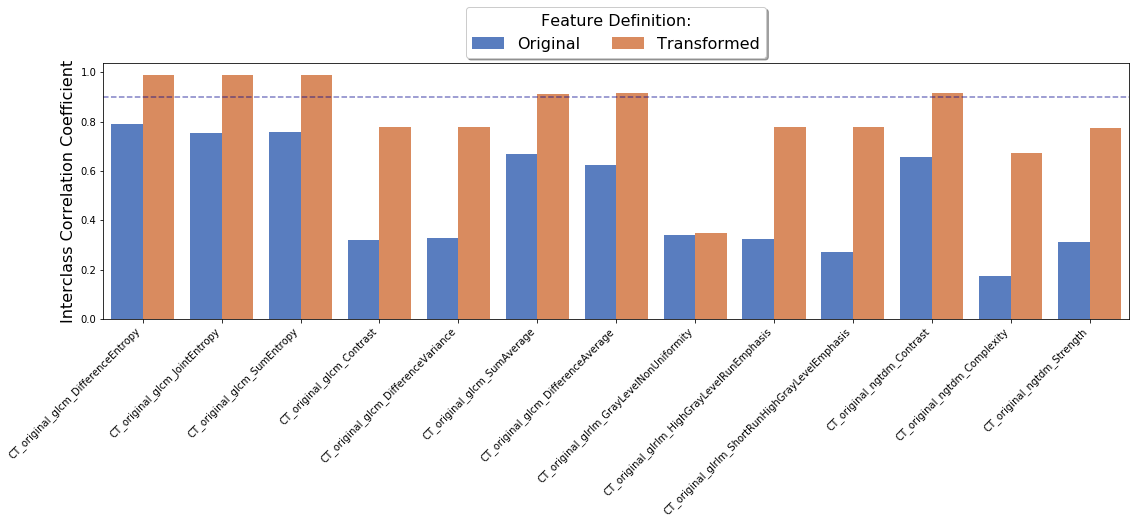

In [15]:
# Plotting original and transformed CT texture features.
plt.figure(figsize=(16, 8))
sns.barplot(
    x=df_icc.index, 
    y='Score', 
    hue='Kind', 
    data=df_icc, 
    palette='muted',
)
plt.ylabel('Interclass Correlation Coefficient', fontsize='16')
plt.xticks(rotation=45, ha='right')
plt.axhline(y=0.9, linestyle='--', alpha=0.5, color='darkblue')
plt.legend(
    fontsize=16,
    title='Feature Definition:', title_fontsize=16,
    loc='upper center', 
    bbox_to_anchor=(0.5, 1.25),
    ncol=2, 
    fancybox=True, 
    shadow=True
)
plt.tight_layout()

# Remove GL Discr. Duplicates from Dataset

In [16]:
df_icc.index.size, np.unique(df_icc.index).size

(26, 13)

In [17]:
stable_features = np.unique(
    np.concatenate((df_icc_all_feats.index, df_icc.index))
)
len(stable_features)

28

In [18]:
list(stable_features)

['CT_original_glcm_Contrast',
 'CT_original_glcm_Correlation',
 'CT_original_glcm_DifferenceAverage',
 'CT_original_glcm_DifferenceEntropy',
 'CT_original_glcm_DifferenceVariance',
 'CT_original_glcm_JointEntropy',
 'CT_original_glcm_MCC',
 'CT_original_glcm_SumAverage',
 'CT_original_glcm_SumEntropy',
 'CT_original_gldm_GrayLevelNonUniformity',
 'CT_original_glrlm_GrayLevelNonUniformity',
 'CT_original_glrlm_HighGrayLevelRunEmphasis',
 'CT_original_glrlm_ShortRunHighGrayLevelEmphasis',
 'CT_original_ngtdm_Complexity',
 'CT_original_ngtdm_Contrast',
 'CT_original_ngtdm_Strength',
 'PET_original_glcm_Correlation',
 'PET_original_glcm_DifferenceEntropy',
 'PET_original_glcm_Idmn',
 'PET_original_glcm_Idn',
 'PET_original_glcm_Imc1',
 'PET_original_glcm_JointEntropy',
 'PET_original_glcm_MCC',
 'PET_original_glcm_SumEntropy',
 'PET_original_gldm_DependenceEntropy',
 'PET_original_gldm_SmallDependenceLowGrayLevelEmphasis',
 'PET_original_glrlm_RunEntropy',
 'PET_original_ngtdm_Coarseness']

In [19]:
# Remove duplicates of stable features.
for col in stable_features:
    feat_dupls = features.filter(regex=col)
    col_values = np.copy(feat_dupls.values[:, 0])
    features.drop(feat_dupls.columns, inplace=True, axis=1)
    features[col] = col_values

In [20]:
features.shape

(198, 391)

In [21]:
features.head()

,CT_original_glcm_Autocorrelation_32bins,CT_original_glcm_Autocorrelation_64bins,CT_original_glcm_Autocorrelation_128bins,CT_original_glcm_ClusterProminence_32bins,CT_original_glcm_ClusterProminence_64bins,CT_original_glcm_ClusterProminence_128bins,CT_original_glcm_ClusterShade_32bins,CT_original_glcm_ClusterShade_64bins,CT_original_glcm_ClusterShade_128bins,CT_original_glcm_ClusterTendency_32bins,...,PET_original_glcm_Idmn,PET_original_glcm_Idn,PET_original_glcm_Imc1,PET_original_glcm_JointEntropy,PET_original_glcm_MCC,PET_original_glcm_SumEntropy,PET_original_gldm_DependenceEntropy,PET_original_gldm_SmallDependenceLowGrayLevelEmphasis,PET_original_glrlm_RunEntropy,PET_original_ngtdm_Coarseness
2,15.835837,48.879403,159.175192,0.568382,4.436457,74.353620,-0.189067,-0.656599,-6.203428,0.081488,...,0.996554,0.958901,-0.401599,9.094826,0.976867,6.677251,8.447828,0.000596,6.284960,0.004304
4,11.917136,40.804717,150.846648,2.494158,27.367789,416.195648,-0.253104,-3.083318,-25.933402,0.998702,...,0.996056,0.959224,-0.431777,7.790969,0.974165,5.934518,8.060332,0.000816,5.934323,0.005613
5,23.695404,63.013916,231.810872,2.666043,26.308717,394.079421,-0.782760,-1.967129,-9.841202,0.571788,...,0.996952,0.959670,-0.429131,8.063052,0.973001,6.114282,8.096305,0.000583,5.822272,0.004320
8,34.895257,118.113705,450.544195,17.429172,204.478150,3246.675728,-2.859567,-16.925186,-133.055739,0.638704,...,0.998161,0.971009,-0.476741,6.922901,0.975322,5.511231,8.258019,0.000387,5.732920,0.000902
10,15.917349,48.319152,163.419029,0.462631,12.194580,235.850203,-0.118145,-1.925310,-18.828114,0.079443,...,0.996385,0.958955,-0.461470,6.139451,0.959658,4.953721,7.630062,0.000606,5.182933,0.003926


In [22]:
features.to_csv('./../../data_source/to_analysis/hassan_all_features_original_images.csv')